In [17]:
from sdof_oscillators import sdof_solution, add_noise, generate_excitation

import numpy as np
import torch

from findiff import FinDiff

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
plt.rcParams.update({
    'text.usetex' : True,
    'mathtext.fontset' : 'stix',
    'font.family' : 'STIXGeneral'
})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


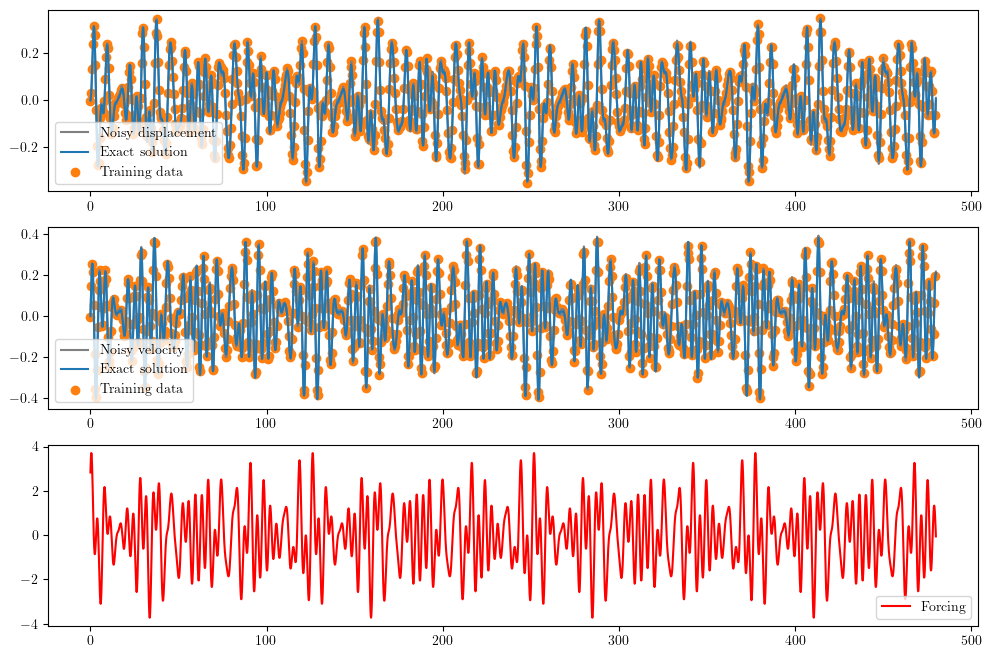

In [29]:
nt = 4096
t = np.linspace(0,480,nt)

F0 = 0.1  # N

excitation = {
    "type" : "rand_phase_ms",
    "F0" : F0,
    "freqs" :   np.array([0.7, 0.85, 1.6, 1.8]),
    "Sx" :      np.array([1.0, 1.0, 1.0, 1.0])
}

F = generate_excitation(t, excitation)
excitation["F"] = F.reshape(-1)

### Generate training and ground truth
m = 10.0
c = 1.0
k = 15.0
k3 = 00.0

wn = np.sqrt(k/m)
zeta = c/(2*m*wn)
wd = wn*np.sqrt(1-zeta**2)

gt_config = {
    "nonlinearity" : "cubic",
    # "m_norm" : False,
    "m_norm" : False,
    "params" : {
        "m" : m,
        "k" : k,
        "c" : c,
        "k3" : k3
    },
    "init_conds" : {
        "x0" : 0.0,
        "v0" : 0.0
    },
    "forcing" : excitation
}

x, v = sdof_solution(t, gt_config)
x_noisy = add_noise(x.view(-1,1), 0.02)
v_noisy = add_noise(v.view(-1,1), 0.02)
t = torch.tensor(t).view(-1,1).to(torch.float32)

# slice out a number of points from the start of the signal
sub_ind = np.arange(0, int(nt/1), 4)

t_data = t[sub_ind]
x_data = x_noisy[sub_ind]
v_data = v_noisy[sub_ind]

fig, axs= plt.subplots(3,1, figsize=(12,8))
axs[0].plot(t, x_noisy, color="gray", label="Noisy displacement")
axs[0].plot(t, x, label="Exact solution")
axs[0].scatter(t_data, x_data, color="tab:orange", label="Training data")
axs[0].legend()

axs[1].plot(t, v_noisy, color="gray", label="Noisy velocity")
axs[1].plot(t, v, label="Exact solution")
axs[1].scatter(t_data, v_data, color="tab:orange", label="Training data")
axs[1].legend()

axs[2].plot(t, excitation["F"], color="red", label="Forcing")
axs[2].legend()

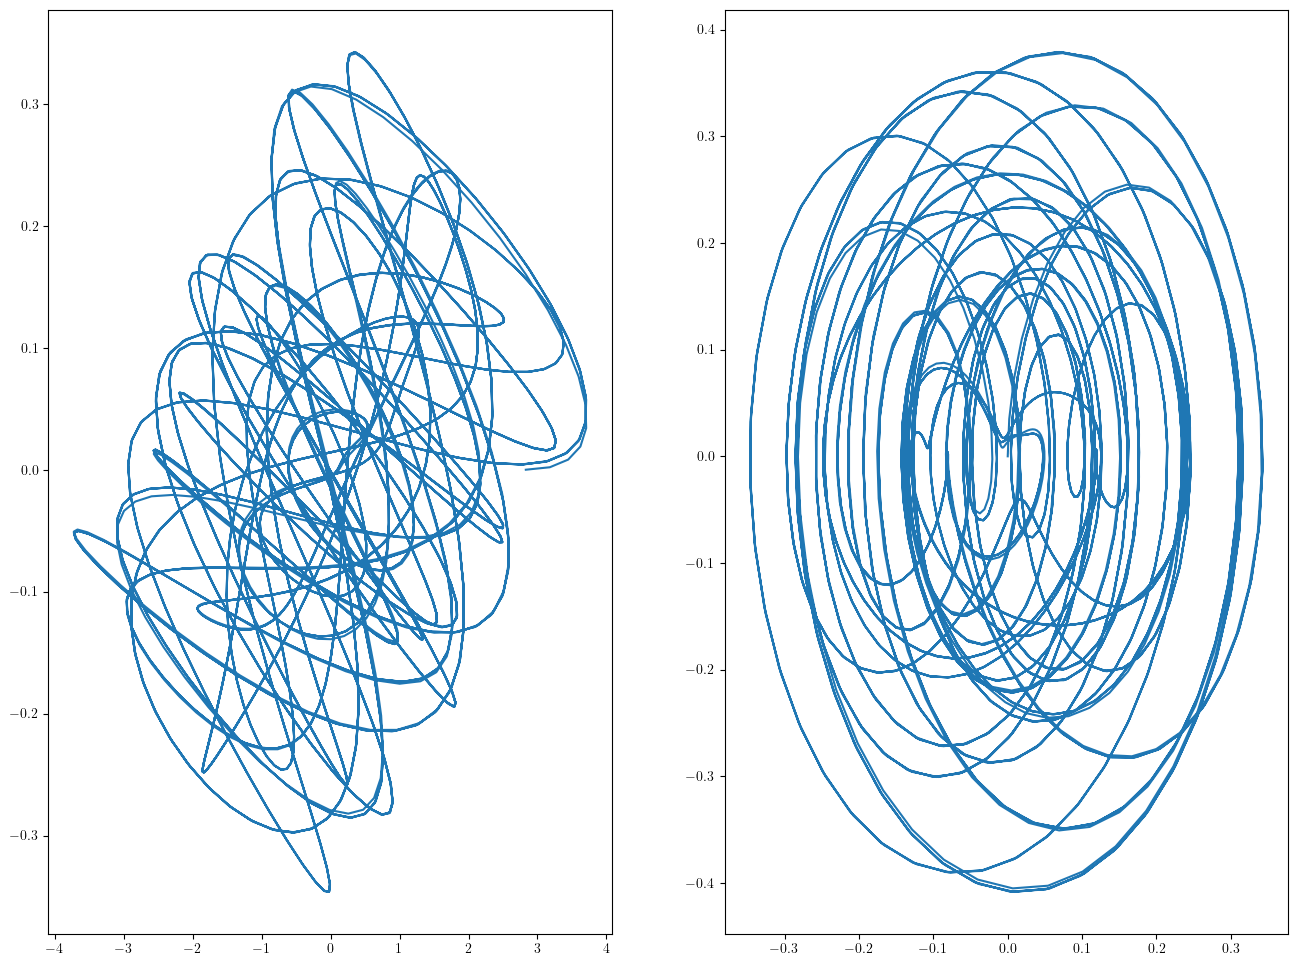

In [30]:
dt = t[1].item()-t[0].item()
d_dt = FinDiff(0, dt, 1)
a = d_dt(v.numpy())

fig, axs = plt.subplots(1, 2, figsize=(16,12))

axs[0].plot(excitation["F"], x)
axs[1].plot(x, v)